#### Creating a Machine Learning Model to predcit the event based on Φ-OTDR readings

We import the required libraries wherever and whenever required as per usage

In [1]:
import pandas as pd
df = pd.read_csv("images2.csv", names=["file_path","target"])
print(df.describe)


<bound method NDFrame.describe of                           file_path  target
0        ../trainData/drop/5491.jpg       0
1        ../trainData/drop/2712.jpg       0
2        ../trainData/drop/1075.jpg       0
3        ../trainData/drop/1237.jpg       0
4        ../trainData/drop/2854.jpg       0
...                             ...     ...
20995  ../trainData/qiaoji/2754.jpg       4
20996  ../trainData/qiaoji/3925.jpg       4
20997  ../trainData/qiaoji/4501.jpg       4
20998   ../trainData/qiaoji/252.jpg       4
20999  ../trainData/qiaoji/2526.jpg       4

[21000 rows x 2 columns]>


In [2]:
import numpy as np
from PIL import Image
from PIL import ImageFilter

from skimage.filters import prewitt_h,prewitt_v

Extracting basic features such as mean, std, corr and zero crossings

In [3]:
def img_mean(npa):  return np.mean(npa)

def img_std(npa):   return np.std(npa)

def img_corr(image):
    img_med = image.filter(ImageFilter.MedianFilter(size = 3))
    return np.corrcoef(image,img_med).mean()

def img_zcrs(npa):
    zcr = np.mean(npa, axis = 0) - npa.mean().mean()
    zero_crossings = np.where(np.diff(np.signbit(zcr)))[0]
    return len(zero_crossings)

def img_skew(npa):  return pd.DataFrame(npa).skew().mean()

def img_kurt(npa):  return pd.DataFrame(npa).kurtosis().mean()

def img_ver_edge(npa): return prewitt_v(npa).mean()

def img_hor_edge(npa): return prewitt_h(npa).mean()


Extracting the features such as number of data points in certain frequency ranges

In [4]:
def freq_ranges(npa):
    col = np.mean(npa, axis = 0)
    bt_0_50 = ((50>col) & (col>=0)).sum()
    bt_50_100 = ((100>col) & (col>=50)).sum()
    bt_100_150 = ((150>col) & (col>=100)).sum()
    ab_150 = (col>=150).sum()
    return bt_0_50, bt_50_100, bt_100_150, ab_150

def stren(npa): 
    temperory=freq_ranges(npa)
    strn=temperory[2]+temperory[3]
    return strn
    
def event(npa):
    zcr = np.mean(npa, axis = 0) - 100
    ev = len(np.where(np.diff(np.signbit(zcr)))[0])
    return ev

def img_stren(npa):

    if event(npa)==0:
        return 0
    else:
        val=2*stren(npa)/event(npa)
        return val

def spectral_energy(npa):
  mat=npa
  total=npa.sum()
  x=[]
  for i in range(4):
    count=0
    for j in range((len(mat)//4)*i,(len(mat)//4)*(i+1)):
      count+=sum(mat[j])
    x.append(count/total)
  return x[0],x[1],x[2],x[3]

Overall Extraction of features from the Images

In [5]:
dfm = pd.DataFrame( columns = ["mean", "std", "corr", "zcrs"] )

temp_df = pd.DataFrame( columns = ["skew", "kurtosis", "event_strength"] )

dup_df = pd.DataFrame( columns = ["edge_v", "edge_h"])

se_df = pd.DataFrame( columns = ["x[0]", "x[1]", "x[2]", "x[3]" ])

for imgs in df.file_path:
    image = Image.open(imgs)
    npa = np.array(image)
    
    dfm.loc[len(dfm)] = [ img_mean(npa), img_std(npa),img_corr(image), img_zcrs(npa) ]
    temp_df.loc[len(temp_df)] = [ img_skew(npa), img_kurt(npa), img_stren(npa)]
    dup_df.loc[len(dup_df)] = [img_ver_edge(npa), img_hor_edge(npa)]
    list = spectral_energy(npa)
    se_df.loc[len(se_df)] = list

dfm = pd.concat([dfm, temp_df], axis=1)
dfm = pd.concat([dfm, dup_df], axis =1)
dfm = pd.concat([dfm, se_df], axis=1)
dfm['target'] = df.target
dfm

,mean,std,corr,zcrs,skew,kurtosis,event_strength,edge_v,edge_h,x[0],x[1],x[2],x[3],target
0,25.765820,37.987719,0.641946,38.0,1.693545,4.235893,6.000000,-0.000297,0.001941,0.123381,0.288142,0.289867,0.298609,0
1,24.484570,40.607841,0.704699,18.0,1.683911,4.448071,4.000000,-0.000099,0.002135,0.124027,0.312687,0.314106,0.249180,0
2,25.393633,38.616103,0.636090,26.0,1.581144,3.511482,4.500000,-0.000152,0.003218,0.109798,0.266535,0.300964,0.322703,0
3,38.179883,52.298636,0.582311,36.0,1.662758,4.098637,5.142857,0.004713,0.004995,0.093242,0.236650,0.300809,0.369299,0
4,32.750898,47.866475,0.686309,24.0,1.601055,4.052781,3.000000,0.000144,0.003870,0.118435,0.258129,0.284491,0.338945,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,41.145313,49.929015,0.486868,36.0,1.436900,2.693499,2.857143,-0.002108,0.005676,0.094429,0.239033,0.285022,0.381517,4
20996,22.244258,40.136412,0.669736,10.0,1.632976,3.840018,2.000000,-0.000881,0.000666,0.141502,0.277087,0.334228,0.247183,4
20997,23.887070,32.084761,0.480300,18.0,1.674582,4.021697,1.200000,-0.000515,0.003082,0.115755,0.269571,0.313459,0.301216,4
20998,24.216875,36.220532,0.556774,6.0,1.662630,4.064199,2.500000,0.000119,0.002145,0.120955,0.290392,0.315316,0.273337,4


We split the dataframe into the required features and target to train the model

In [6]:
X = dfm.drop('target',axis='columns')
y = dfm.target

from sklearn.preprocessing we import StandardScaler to remove the mean and scales each feature/variable to unit variance


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.20061701,  0.10082043,  1.44455375, ...,  0.44499414,
        -0.44067398, -0.18257587],
       [-0.28937809,  0.26485498,  1.84970224, ...,  0.99050104,
         0.39962908, -0.74755305],
       [-0.22640102,  0.14016085,  1.40674595, ..., -0.0352248 ,
        -0.05596038,  0.09282124],
       ...,
       [-0.33077106, -0.26873829,  0.40092621, ...,  0.03225498,
         0.37721028, -0.15278363],
       [-0.3079232 , -0.00981549,  0.89466378, ...,  0.49499257,
         0.44160167, -0.47143098],
       [ 1.63031299,  1.34855951, -0.34311493, ..., -1.00232305,
        -0.72361861,  0.99350207]])

In [8]:
from prettytable import PrettyTable
tab = PrettyTable()
tab.title = 'ML Model Scores with different splits'
tab.field_names = ['Split Ratio', 'SupportVectorMachine']

We use train_test_split to split the data for training the model and for testing the model,\
we can give paramaters such as test_size to determine how much of the data is given to testing and training, \
then import the required model from respective library and create a model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

splits = [0.1]

for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = split, random_state = 40)

    model_svc = SVC(C=36, kernel="rbf")
    model_svc.fit(X_train, y_train)
    svcscore = model_svc.score(X_test, y_test)
    #scoressvc = cross_val_score(SVC(), X_test, y_test, cv=5)
    #coressvc = scoressvc.mean()

    tab.add_row([f"Split: {split}", svcscore])

Printing all the scores of the Models

In [10]:
C = []
for i in range(10,40):
    C.append(i)

In [11]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('rbf','poly'), 'C':C}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train,y_train)
#GridSearchCV(estimator=SVC(),
#             param_grid={'C':C, 'kernel': ('rbf','poly')})
sorted(clf.cv_results_)

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [12]:
dftest = pd.DataFrame(clf.cv_results_)
dftest

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.077804,0.425372,2.156392,0.149576,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.853175,0.852116,0.860582,0.853175,0.863757,0.856561,0.004704,30
1,6.153709,0.721904,0.862023,0.110959,10,poly,"{'C': 10, 'kernel': 'poly'}",0.829365,0.824603,0.839683,0.829894,0.836243,0.831958,0.005350,60
2,3.227518,0.188448,2.077196,0.057362,11,rbf,"{'C': 11, 'kernel': 'rbf'}",0.853439,0.853175,0.859524,0.854497,0.863757,0.856878,0.004136,29
3,5.036535,0.091448,0.690265,0.143879,11,poly,"{'C': 11, 'kernel': 'poly'}",0.830688,0.827778,0.839683,0.830952,0.837566,0.833333,0.004511,59
4,3.437458,0.442850,2.479250,0.460005,12,rbf,"{'C': 12, 'kernel': 'rbf'}",0.853439,0.855291,0.860053,0.856614,0.862963,0.857672,0.003417,28
5,5.296686,0.453823,0.667336,0.061805,12,poly,"{'C': 12, 'kernel': 'poly'}",0.830688,0.828836,0.838889,0.831746,0.838095,0.833651,0.004069,58
6,3.206268,0.454358,2.194133,0.192002,13,rbf,"{'C': 13, 'kernel': 'rbf'}",0.853704,0.854762,0.859524,0.857407,0.864286,0.857937,0.003771,27
7,5.593802,0.895128,0.700895,0.135895,13,poly,"{'C': 13, 'kernel': 'poly'}",0.830952,0.829101,0.840476,0.832011,0.837831,0.834074,0.004332,57
8,3.060636,0.491274,2.471416,0.194344,14,rbf,"{'C': 14, 'kernel': 'rbf'}",0.854233,0.855026,0.859259,0.857672,0.864286,0.858095,0.003583,25
9,5.102382,0.285555,0.673038,0.137466,14,poly,"{'C': 14, 'kernel': 'poly'}",0.831746,0.829630,0.841534,0.832275,0.839683,0.834974,0.004722,56


In [13]:
file_data='svc2.csv'
dftest.to_csv(file_data)

In [14]:
print(tab)

+-----------------------------------------+
|  ML Model Scores with different splits  |
+---------------+-------------------------+
|  Split Ratio  |   SupportVectorMachine  |
+---------------+-------------------------+
|   Split: 0.1  |    0.8666666666666667   |
+---------------+-------------------------+


We use Seaborn library to plot the confusion matrix to check the truth matrix i.e, \
how many correct predictions are there and for how many the model was confused to predict

We use the last model to plot the confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix

y_pred_svc = model_svc.predict(X_test)

cm_svc = confusion_matrix(y_test, y_pred_svc)

In [16]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test, y_pred_svc))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred_svc, digits=3))

[[333   8   1   1  67]
 [  6 322  57   9   9]
 [  0  20 408   4   3]
 [  1  19  11 394   0]
 [ 49  14   0   1 363]]
              precision    recall  f1-score   support

           0      0.856     0.812     0.834       410
           1      0.841     0.799     0.819       403
           2      0.855     0.938     0.895       435
           3      0.963     0.927     0.945       425
           4      0.821     0.850     0.835       427

    accuracy                          0.867      2100
   macro avg      0.867     0.865     0.866      2100
weighted avg      0.868     0.867     0.866      2100



Text(0.5, 1.0, 'SupportVectorMachine')

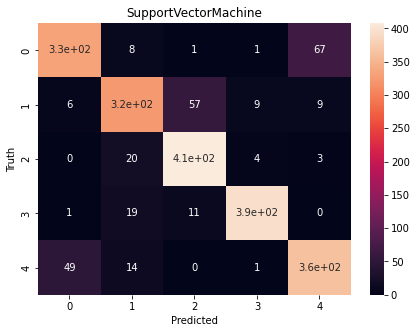

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(7,5))

sn.heatmap(cm_svc, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('SupportVectorMachine')